In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import sys
sys.path.append("../")
import torch
assert torch.cuda.is_available()
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
from tqdm.auto import tqdm
import json
from train import eval
from Utils import load
import networkx as nx
import scipy
import copy

In [ ]:
pruners = np.array(
    [
        'cs',
        'grasp',
        'sf',
        'mica_erk_shuffle',
        'mica_igq_shuffle',
        'mica_cs_rand_effective_comp',
        'mica_grasp_rand_effective_comp',
        'mica_sf_rand_effective_comp',
        'mica_erk_rand_effective_comp',
        'mica_igq_rand_effective_comp'
    ],
    dtype=object
    )

colors = {
    'cs'         : plt.cm.tab10(9),
    'grasp'      : plt.cm.tab10(8),
    'sf'         : plt.cm.tab10(6),
    'mica_cs_rand'    : plt.cm.tab10(9),
    'mica_grasp_rand' : plt.cm.tab10(8),
    'mica_sf'    : plt.cm.tab10(6),
    'mica_sf_rand' : plt.cm.tab10(6),
    'mica_sf_min'  : plt.cm.tab10(6),
    'mica_sf_max'  : plt.cm.tab10(6),
    'mica_erk'   : plt.cm.tab10(4),
    'mica_erk_rand' : plt.cm.tab10(4),
    'mica_igq'   : plt.cm.tab10(3),
    'mica_igq_rand' : plt.cm.tab10(3),
    'mica_igq_min'  : plt.cm.tab10(8),
    'mica_igq_max'  : plt.cm.tab10(7),
}

markers = {
    'cs'         : "^", 
    'grasp'      : "h", 
    'sf'         : "H", 
    'mica_cs_rand'    : "^", 
    'mica_grasp_rand' : "h", 
    'mica_sf_rand'    : "H",
    'mica_sf_min'    : "H",
    'mica_sf_max'    : "H",
    'mica_erk'   : "p", 
    'mica_erk_rand' : "p", 
    'mica_igq'   : "*",
    'mica_igq_rand' : "*",
    'mica_igq_min'  : "<",
    'mica_igq_max'  : ">",
}

pruner_names = {
    'cs'                 : 'RbPI-SNIP',
    'grasp'              : 'RbPI-GraSP',
    'sf'                 : 'RbPI-SynFlow',
    'mica_cs_shuffle'    : 'RPI-SNIP',
    'mica_grasp_shuffle' : 'RPI-GraSP',
    'mica_sf_shuffle'    : 'RPI-SynFlow',
    'mica_erk_shuffle'   : 'RPI-ERK',
    'mica_igq_shuffle'   : 'RPI-IGQ',
    'mica_cs_rand_effective_comp'    : '$\\bf{MiCA}$-$\\bf{SNIP}$',
    'mica_grasp_rand_effective_comp' : '$\\bf{MiCA}$-$\\bf{GraSP}$',
    'mica_sf_rand_effective_comp'    : '$\\bf{MiCA}$-$\\bf{SynFlow}$',
    'mica_erk_rand_effective_comp'   : '$\\bf{MiCA}$-$\\bf{ERK}$',
    'mica_igq_rand_effective_comp'   : '$\\bf{MiCA}$-$\\bf{IGQ}$',
    }

pepochs = {
    'cs'         : '1',
    'grasp'      : '1',
    'sf'         : '100',
    'mica_cs_rand'    : '1',
    'mica_grasp_rand' : '1',
    'mica_sf'    : '1',
    'mica_sf_rand' : '1',
    'mica_sf_max'  : '1',
    'mica_sf_min'  : '1',
    'mica_erk'   : '1',
    'mica_erk_rand'   : '1',
    'mica_igq'   : '1',
    'mica_igq_rand'  : '1',
    'mica_igq_min'   : '1',
    'mica_igq_max'   : '1',
}

for pruner in pruners:
    if '_shuffle' in pruner:
        colors[pruner]  = colors[pruner.replace('_shuffle', '')]
        markers[pruner]  = markers[pruner.replace('_shuffle', '')]
        pepochs[pruner] = pepochs[pruner.replace('_shuffle', '')]
    elif '_effective_comp' in pruner:
        colors[pruner]  = colors[pruner.replace('_effective_comp', '')]
        markers[pruner]  = markers[pruner.replace('_effective_comp', '')]
        pepochs[pruner] = pepochs[pruner.replace('_effective_comp', '')]
    elif '_rand' in pruner:
        colors[pruner]  = colors[pruner.replace('_rand', '')]
        markers[pruner]  = markers[pruner.replace('_rand', '')]
        pepochs[pruner] = pepochs[pruner.replace('_rand', '')]


runs = [0, 1, 2]
max_run_num = len(runs)

print(pruners)

In [3]:
def get_experimentid(pruner, ratio, pepochs, run_num, expid):
    if '_shuffle' in pruner:
        base_dir = f'../Results/data/singleshot/{expid}_shuffle'
        p_name = pruner.replace('_shuffle', '')
    elif '_min' in pruner:
        if '_effective_comp' in pruner:
            base_dir = f'../Results/data/singleshot/{expid}_min_effective_comp'
            p_name = pruner.replace('_min_effective_comp', '')
        else:
            base_dir = f'../Results/data/singleshot/{expid}_min'
            p_name = pruner.replace('_min', '')
    elif '_max' in pruner:
        if '_effective_comp' in pruner:
            base_dir = f'../Results/data/singleshot/{expid}_max_effective_comp'
            p_name = pruner.replace('_max_effective_comp', '')
        else:
            base_dir = f'../Results/data/singleshot/{expid}_max'
            p_name = pruner.replace('_max', '')
    elif '_rand' in pruner:
        if '_effective_comp' in pruner:
            base_dir = f'../Results/data/singleshot/{expid}_rand_effective_comp'
            p_name = pruner.replace('_rand_effective_comp', '')
        else:
            base_dir = f'../Results/data/singleshot/{expid}_rand'
            p_name = pruner.replace('_rand', '')
    else:
        base_dir = f'../Results/data/singleshot/{expid}'
        p_name = pruner
    b_dir  = f'{base_dir}'
    experimentid =  f'{b_dir}/' \
                    f'{p_name}-{ratio}-{pepochs}/' \
                    f'run_{run_num}/' 
    return experimentid

def zero_to_nan(values):
    return [float('nan') if x==0 else x for x in values]

def get_ordered_list(l, order):
    out = []
    for i in order:
        out.append(l[i])
    return out

In [ ]:
expid = 'cifar10_lottery_resnet20'
ratios = [
    '0.5', '1.0', '1.5', '2.0', 
    '2.5', '3.0', '3.5', '4.0', 
    ]
resnet_baselines = []
for r, run_num in enumerate(runs):
    experimentid      = get_experimentid('mica_igq_max', '0.0', '1', run_num, expid)
    train_result_file = experimentid + 'post-train.pkl'
    train_result      = pd.read_pickle(train_result_file)
    resnet_baselines.append(np.max(train_result['test_top1_acc']))
resnet_baseline = np.mean(resnet_baselines)
print(resnet_baseline)

resnet_x_ratios           = {}
resnet_effective_x_ratios = {}
resnet_accs               = {}

for l, pruner in enumerate(pruners):
    resnet_x_ratios[pruner]           = np.zeros((len(ratios)))
    resnet_effective_x_ratios[pruner] = np.zeros((len(ratios)))
    resnet_accs[pruner]               = np.zeros((len(ratios)))
    for i, ratio in enumerate(tqdm(ratios, desc=pruner)): 
        x_ratio   = []
        effective_x_ratio = []
        acc       = []
        n_errors  = 0
        for r, run_num in enumerate(runs):
            experimentid      = get_experimentid(pruner, ratio, pepochs[pruner], run_num, expid)
            model_file        = experimentid + 'model.pt'
            train_result_file = experimentid + 'post-train.pkl'
            compression_file  = experimentid + 'compression.pkl'
            try:
                train_result      = pd.read_pickle(train_result_file)
            except:
                n_errors += 1
                continue
            compression       = pd.read_pickle(compression_file)
            prunable          = compression['prunable']==True
            weight            = compression['param']=='weight'
            modules           = compression[np.logical_and(prunable, weight)]['module']
            densities         = np.array(compression[np.logical_and(prunable, weight)]['density'])
            shape             = compression[np.logical_and(prunable,weight)]['shape']
            e                 = np.array([np.prod(s) for s in shape]) * (densities)
            
            if np.all(e == 0):                
                actual_comp = float('nan')
            else:
                actual_comp = np.sum(np.array([np.prod(s) for s in shape])) / np.sum(e)
            x_ratio.append(actual_comp)
            acc.append(np.max(train_result['test_top1_acc']))

            with open(experimentid + 'args.json') as f:
                args = json.load(f)
            input_shape, num_classes = load.dimension(args['dataset']) 
            loss = nn.CrossEntropyLoss()
            if i == 0 and r == 0:
                test_loader, _, _ = load.dataloader(
                    args['dataset'], args['test_batch_size'], args['test_batch_size'],
                    False, args['workers'], 0, 0)
                dataset = args['dataset']
                test_batch_size = args['test_batch_size']
                workers = args['workers']
                (data, _) = next(iter(test_loader))
                input_dim = list(data[0,:].shape)
                input = torch.ones([1] + input_dim).to('cuda')
            assert args['seed'] == run_num * 1000 # adhoc
            assert args['run_number'] == str(run_num)
            assert dataset == args['dataset']
            assert test_batch_size == args['test_batch_size']
            assert workers == args['workers']

            model = load.model(args['model'], args['model_class'])(
                input_shape, num_classes, args['dense_classifier'], args['pretrained']).to('cuda')
            model.load_state_dict(torch.load(model_file))
            print(f'Forward :')
            model.set_effective_sparsity(is_forward=True, x=input)
            print(f'Backward :')
            model.set_effective_sparsity(is_forward=False, x=None)

            effective_densities = []
            set_modules = set(modules.unique())
            for n, m in model.named_modules():
                if hasattr(m, 'weight_mask') and n in set_modules:
                    effective_densities.append((m.weight_mask.sum() / m.weight_mask.numel()).to('cpu'))
            effective_densities = np.array(effective_densities)
            e = np.array([np.prod(s) for s in shape]) * (effective_densities)
            if np.all(e == 0):                
                actual_comp = float('nan')
            else:
                actual_comp = np.sum(np.array([np.prod(s) for s in shape])) / np.sum(e)
            effective_x_ratio.append(actual_comp)
        if n_errors == len(runs):
            pass
        elif n_errors == 0:
            resnet_x_ratios[pruner][i]           = np.mean(x_ratio)    
            resnet_effective_x_ratios[pruner][i] = np.mean(effective_x_ratio)
            resnet_accs[pruner][i]               = np.mean(acc)  
        else:
            raise ValueError
    resnet_x_ratios[pruner]           = resnet_x_ratios[pruner][resnet_x_ratios[pruner] != 0] 
    resnet_effective_x_ratios[pruner] = resnet_effective_x_ratios[pruner][resnet_effective_x_ratios[pruner] != 0]
    resnet_accs[pruner]               = resnet_accs[pruner][resnet_accs[pruner] != 0]

In [ ]:
expid = 'cifar10_lottery_vgg16_bn'
ratios = [
    '0.5', '1.0', '1.5', 
    '2.0', '2.5', '3.0', 
    '3.5', '4.0', '4.5',
    '5.0', '5.5', '6.0'
    ]
vgg_baselines = []
for r, run_num in enumerate(runs):
    experimentid      = get_experimentid('mica_igq_min', '0.0', '1', run_num, expid)
    train_result_file = experimentid + 'post-train.pkl'
    train_result      = pd.read_pickle(train_result_file)
    vgg_baselines.append(np.max(train_result['test_top1_acc']))
vgg_baseline = np.mean(vgg_baselines)
print(vgg_baseline)

vgg_x_ratios           = {}
vgg_effective_x_ratios = {}
vgg_accs               = {}

for l, pruner in enumerate(pruners):
    vgg_x_ratios[pruner]           = np.zeros((len(ratios)))
    vgg_effective_x_ratios[pruner] = np.zeros((len(ratios)))
    vgg_accs[pruner]               = np.zeros((len(ratios)))
    for i, ratio in enumerate(tqdm(ratios, desc=pruner)): 
        x_ratio   = []
        effective_x_ratio = []
        acc       = []
        n_errors  = 0
        for r, run_num in enumerate(runs):
            experimentid      = get_experimentid(pruner, ratio, pepochs[pruner], run_num, expid)
            model_file        = experimentid + 'model.pt'
            train_result_file = experimentid + 'post-train.pkl'
            compression_file  = experimentid + 'compression.pkl'
            try:
                train_result      = pd.read_pickle(train_result_file)
            except:
                n_errors += 1
                continue
            compression       = pd.read_pickle(compression_file)
            prunable          = compression['prunable']==True
            weight            = compression['param']=='weight'
            modules           = compression[np.logical_and(prunable, weight)]['module']
            densities         = np.array(compression[np.logical_and(prunable, weight)]['density'])
            shape             = compression[np.logical_and(prunable,weight)]['shape']
            e                 = np.array([np.prod(s) for s in shape]) * (densities)
            
            if np.all(e == 0):                
                actual_comp = float('nan')
            else:
                actual_comp = np.sum(np.array([np.prod(s) for s in shape])) / np.sum(e)
            x_ratio.append(actual_comp)
            acc.append(np.max(train_result['test_top1_acc']))

            with open(experimentid + 'args.json') as f:
                args = json.load(f)
            input_shape, num_classes = load.dimension(args['dataset']) 
            loss = nn.CrossEntropyLoss()
            if i == 0 and r == 0:
                test_loader, _, _ = load.dataloader(
                    args['dataset'], args['test_batch_size'], args['test_batch_size'],
                    False, args['workers'], 0, 0)
                dataset = args['dataset']
                test_batch_size = args['test_batch_size']
                workers = args['workers']
                (data, _) = next(iter(test_loader))
                input_dim = list(data[0,:].shape)
                input = torch.ones([1] + input_dim).to('cuda')
            assert args['seed'] == run_num * 1000 # adhoc
            assert args['run_number'] == str(run_num)
            assert dataset == args['dataset']
            assert test_batch_size == args['test_batch_size']
            assert workers == args['workers']

            model = load.model(args['model'], args['model_class'])(
                input_shape, num_classes, args['dense_classifier'], args['pretrained']).to('cuda')
            model.load_state_dict(torch.load(model_file))
            print(f'Forward :')
            model.set_effective_sparsity(is_forward=True, x=input)
            print(f'Backward :')
            model.set_effective_sparsity(is_forward=False, x=None)

            effective_densities = []
            set_modules = set(modules.unique())
            for n, m in model.named_modules():
                if hasattr(m, 'weight_mask') and n in set_modules:
                    effective_densities.append((m.weight_mask.sum() / m.weight_mask.numel()).to('cpu'))
            effective_densities = np.array(effective_densities)
            e = np.array([np.prod(s) for s in shape]) * (effective_densities)
            if np.all(e == 0):                
                actual_comp = float('nan')
            else:
                actual_comp = np.sum(np.array([np.prod(s) for s in shape])) / np.sum(e)
            effective_x_ratio.append(actual_comp)
        if n_errors == len(runs):
            pass
        elif n_errors == 0:
            vgg_x_ratios[pruner][i]           = np.mean(x_ratio)    
            vgg_effective_x_ratios[pruner][i] = np.mean(effective_x_ratio)
            vgg_accs[pruner][i]               = np.mean(acc)  
        else:
            raise ValueError
    vgg_x_ratios[pruner]           = vgg_x_ratios[pruner][vgg_x_ratios[pruner] != 0] 
    vgg_effective_x_ratios[pruner] = vgg_effective_x_ratios[pruner][vgg_effective_x_ratios[pruner] != 0]
    vgg_accs[pruner]               = vgg_accs[pruner][vgg_accs[pruner] != 0]

## MiCA vs Random Pruning

In [6]:
lw=4
markersize=30
fontsize=35
plt.rcParams["font.family"] = "Segoe UI"

mica_erk_rand_effective_comp
vgg
[3.16227995e+00 1.00000094e+01 3.16229545e+01 9.99985334e+01
 3.16232955e+02 1.10579503e+03 4.78280038e+04            nan
            nan            nan            nan            nan]
[92.46       91.78       89.47333333 87.00666667 82.58666667 76.84333333
 39.30333333 10.         10.         10.         10.         10.        ]
mica_igq_rand_effective_comp
vgg
[3.16228112e+00 1.00000640e+01 3.16231584e+01 1.00004648e+02
 3.16543622e+02 1.16415660e+03 1.79843963e+04]
[92.37       91.94666667 90.91       88.68333333 85.40666667 79.89
 22.33333333]
mica_erk_shuffle
vgg
[3.16227995e+00 1.00000094e+01 3.16229545e+01 9.99985334e+01
 3.16232955e+02 1.10579503e+03 4.78280038e+04            nan
            nan            nan            nan            nan]
[92.58       91.71333333 89.58666667 86.74333333 81.49333333 67.03666667
 12.33       10.         10.         10.         10.         10.        ]
mica_igq_shuffle
vgg
[3.16228112e+00 1.00000640e+01 3.16231584

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


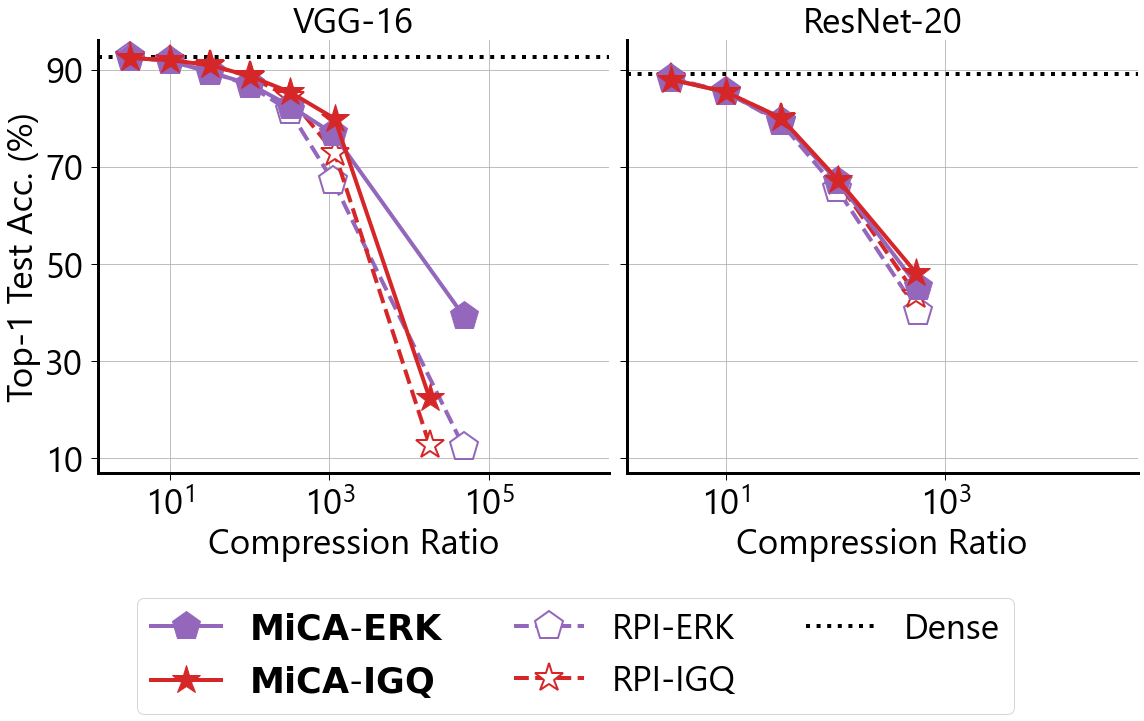

In [7]:
plot_pruners = [
    'mica_erk_rand_effective_comp',
    'mica_igq_rand_effective_comp',
    'mica_erk_shuffle',
    'mica_igq_shuffle',
    ]

fig, axes = plt.subplots(1, 2, figsize=(8*2, 8))

for i, arch in enumerate(['vgg', 'resnet']):
# for i, arch in enumerate(['vgg']):
    if arch == 'vgg':
        baseline = vgg_baseline
        effective_x_ratios = vgg_effective_x_ratios
        accs = vgg_accs
        xticks = [10**(2*i - 1) for i in range(1,4)]
    elif arch == 'resnet':
        baseline = resnet_baseline
        effective_x_ratios = resnet_effective_x_ratios
        accs = resnet_accs
        xticks = [10**(2*i - 1) for i in range(1,6)]
    ax = axes[i]
    ax.axhline(baseline, color = 'black', linewidth = lw, linestyle='dotted', label='Dense', zorder=0)

    zorder = 1
    for l, pruner in enumerate(plot_pruners):
        print(pruner)
        print(arch)
        print(effective_x_ratios[pruner])
        print(accs[pruner])
        if '_shuffle' in pruner:
            linestyle = 'dashed'  
            ax.plot(effective_x_ratios[pruner], accs[pruner], color=colors[pruner], 
                    linestyle=linestyle, lw=lw,
                    marker=markers[pruner], markersize=markersize, markerfacecolor= 'white', markeredgewidth=2,
                    label=pruner_names[pruner],
                    zorder=zorder)
            zorder += 1
        elif 'mica' in pruner:
            linestyle = 'solid'
            ax.plot(effective_x_ratios[pruner], accs[pruner], color=colors[pruner], 
                    linestyle=linestyle, lw=lw,
                    marker=markers[pruner], markersize=markersize,  
                    label=pruner_names[pruner],
                    zorder=zorder+10)
            zorder += 1

    ax.set_ylim(7, 96)
    ax.set_xscale('log')
    ax.set_xticks(xticks)
    ax.set_yticks(np.arange(10, 100, 20))
    ax.minorticks_off()
    
    ax.tick_params(
        which       = "both", bottom    = True,  top   = False,
        labelbottom = True,   left      = True,  right = False,
        labelleft   = True if arch == 'vgg' else False,   
        direction   = 'out',  length    = 7,     width = 1.0,    
        pad         = 8,      labelsize = fontsize
        )
    ax.set_title('VGG-16' if arch == 'vgg' else 'ResNet-20', size=fontsize)
    ax.set_xlabel('Compression Ratio', size=fontsize)
    if i == 0:
        ax.set_ylabel('Top-1 Test Acc. (%)', size=fontsize)
        ax.set_xlim(10**0.1, 10**6.5)
    else:
        ax.set_xlim(10**0.1, 10**4.75)
    ax.grid(True)
    ax.set_axisbelow(True)
    

    # boundary and zoom box
    for dir in ["top", "bottom", "right", "left"]:
        ax.spines[dir].set_linewidth(3)
    ax.spines["right"].set_linestyle((0,(3,3)))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

fig.subplots_adjust(hspace=0.2)
fig.tight_layout()

handles, labels = ax.get_legend_handles_labels()
for nl, label in enumerate(labels):
    print(f'{nl}, {label}')
order = [1,2,3,4,0]
ordered_handles = get_ordered_list(handles, order)
ordered_labels = get_ordered_list(labels, order)
plt.legend(
    handles=ordered_handles,labels=ordered_labels, 
    fontsize=fontsize, loc='upper center', 
    bbox_to_anchor=(-.1, -.25), ncol=3)
os.makedirs('Plots', exist_ok=True)
plt.savefig('./Plots/cifar10_mica_rand_sparsity_distribution.eps', bbox_inches="tight")
plt.savefig('./Plots/cifar10_mica_rand_sparsity_distribution.svg', bbox_inches="tight")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


vgg
mica_cs_rand_effective_comp
[92.28666667 91.33333333 89.84       87.78       83.94666667 73.29333333
 10.         10.         10.         10.         10.         10.        ]
[   3.17003865   10.09526711   32.87195132  115.54719817  456.67581796
 2121.41761791           nan           nan           nan           nan
           nan           nan]
vgg
cs
[92.26       91.28666667 90.04666667 87.89666667 83.32666667 69.86666667
 10.         10.         10.         10.         10.         10.        ]
[   3.17003865   10.09526711   32.87195132  115.54719817  456.67581796
 2121.41761791           nan           nan           nan           nan
           nan           nan]
vgg
mica_grasp_rand_effective_comp
[92.22333333 91.63333333 90.50333333 88.90666667 85.91666667 10.
 10.         10.         10.         10.         10.         10.        ]
[  3.16275952  10.01111482  31.82001484 103.7113329  358.16259615
          nan          nan          nan          nan          nan
          nan    

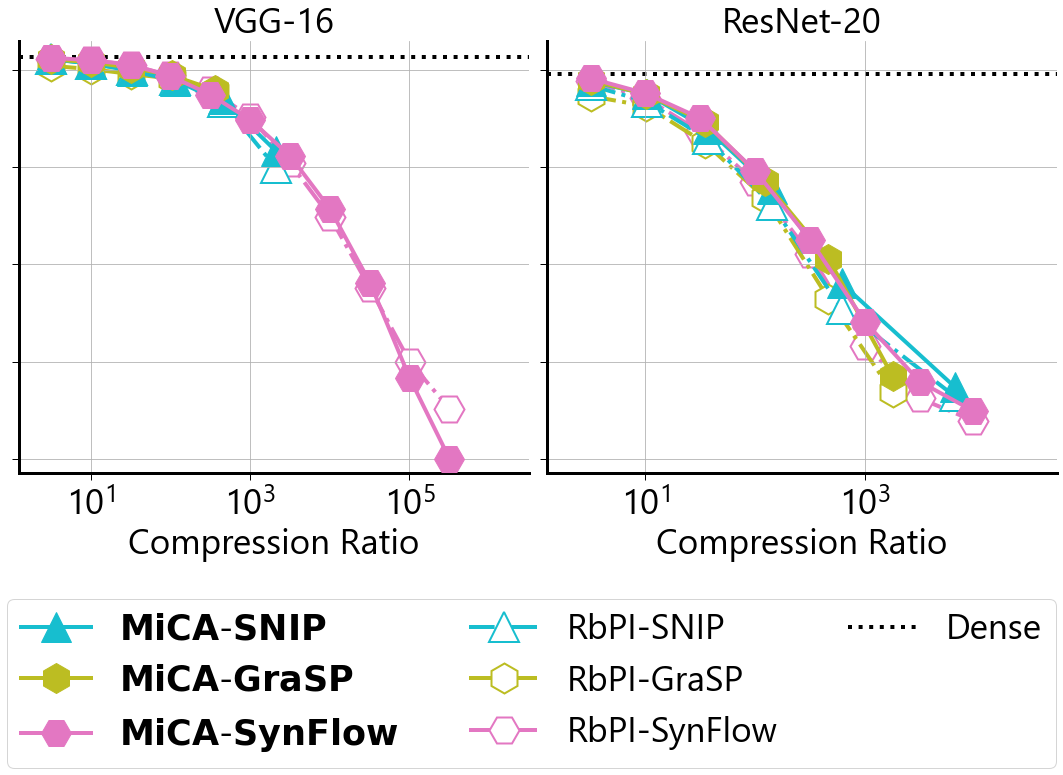

In [8]:
plot_pruners = [
    'mica_cs_rand_effective_comp',
    'cs',
    'mica_grasp_rand_effective_comp',
    'grasp',
    'mica_sf_rand_effective_comp',
    'sf'
    ]

fig, axes = plt.subplots(1, 2, figsize=(8*1.851, 8))

for i, arch in enumerate(['vgg', 'resnet']):
# for i, arch in enumerate(['vgg']):
    if arch == 'vgg':
        baseline = vgg_baseline
        effective_x_ratios = vgg_effective_x_ratios
        accs = vgg_accs
        xticks = [10**(2*i - 1) for i in range(1,4)]
    elif arch == 'resnet':
        baseline = resnet_baseline
        effective_x_ratios = resnet_effective_x_ratios
        accs = resnet_accs
        xticks = [10**(2*i - 1) for i in range(1,6)]
    ax = axes[i]
    ax.axhline(baseline, color = 'black', linewidth = lw, linestyle='dotted', label='Dense', zorder=0)
    ax.scatter(0, 0, marker="", label=' ')
    
    zorder = 1
    for l, pruner in enumerate(plot_pruners):
        print(arch)
        print(pruner)
        print(accs[pruner])
        print(effective_x_ratios[pruner])
        if 'mica' in pruner:
            linestyle = 'solid'
            ax.plot(effective_x_ratios[pruner], accs[pruner], color=colors[pruner], 
                    linestyle=linestyle, lw=lw,
                    marker=markers[pruner], markersize=markersize,  
                    label=pruner_names[pruner],
                    zorder=zorder+10)
            zorder += 1
        else:
            linestyle = 'dashdot'
            ax.plot(effective_x_ratios[pruner], accs[pruner], color=colors[pruner], 
                    linestyle=linestyle, lw=lw,
                    marker=markers[pruner], markersize=markersize,  
                    markerfacecolor= 'white', markeredgewidth=2,
                    label=pruner_names[pruner],
                    zorder=-zorder)
            zorder += 1

    ax.set_ylim(7, 96)
    ax.set_xscale('log')
    ax.set_xticks(xticks)
    ax.set_yticks(np.arange(10, 100, 20))
    ax.minorticks_off()
    
    ax.tick_params(
        which       = "both", bottom    = True,  top   = False,
        labelbottom = True,   left      = True,  right = False,
        labelleft   = False,   
        direction   = 'out',  length    = 7,     width = 1.0,    
        pad         = 8,      labelsize = fontsize
        )
    ax.set_title('VGG-16' if arch == 'vgg' else 'ResNet-20', size=fontsize)
    ax.set_xlabel('Compression Ratio', size=fontsize)
    if i == 0:
        ax.set_xlim(10**0.1, 10**6.5)
    else:
        ax.set_xlim(10**0.1, 10**4.75)
    ax.grid(True)
    ax.set_axisbelow(True)
    

    # boundary and zoom box
    for dir in ["top", "bottom", "right", "left"]:
        ax.spines[dir].set_linewidth(3)
    ax.spines["right"].set_linestyle((0,(3,3)))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

fig.subplots_adjust(hspace=0.2)
fig.tight_layout()

handles, labels = ax.get_legend_handles_labels()
for nl, label in enumerate(labels):
    print(f'{nl}, {label}')
order = [2,4,6,3,5,7,0,1]
ordered_handles = get_ordered_list(handles, order)
ordered_labels = get_ordered_list(labels, order)
plt.legend(
    handles=ordered_handles,labels=ordered_labels, 
    fontsize=fontsize, loc='upper center', 
    bbox_to_anchor=(-.03, -.25), ncol=3)
os.makedirs('Plots', exist_ok=True)
plt.savefig('./Plots/cifar10_mica_rank_sparsity_distribution.eps', bbox_inches="tight")
plt.savefig('./Plots/cifar10_mica_rank_sparsity_distribution.svg', bbox_inches="tight")

## Input Nodes Loss

In [ ]:
expid  = 'cifar10_lottery_vgg16_bn'
ratios = [
    '0.5', '1.0', '1.5', '2.0', 
    '2.5', '3.0', '3.5', '4.0',
    '4.5', '5.0', '5.5', '6.0'
    ]

# pruners = np.array(
#     [
#         'mica_erk_rand_effective_comp',
#         'mica_igq_rand_effective_comp',
#         'mica_erk_shuffle',
#         'mica_igq_shuffle'
#     ],
#     dtype=object
#     )

for pruner in pruners:
    if '_shuffle' in pruner:
        colors[pruner]  = colors[pruner.replace('_shuffle', '')]
        markers[pruner]  = markers[pruner.replace('_shuffle', '')]
        pepochs[pruner] = pepochs[pruner.replace('_shuffle', '')]
    elif '_effective_comp' in pruner:
        colors[pruner]  = colors[pruner.replace('_effective_comp', '')]
        markers[pruner]  = markers[pruner.replace('_effective_comp', '')]
        pepochs[pruner] = pepochs[pruner.replace('_effective_comp', '')]
    elif '_rand' in pruner:
        colors[pruner]  = colors[pruner.replace('_rand', '')]
        markers[pruner]  = markers[pruner.replace('_rand', '')]
        pepochs[pruner] = pepochs[pruner.replace('_rand', '')]

vgg_pruner_n_losses    = {}
vgg_pruner_n_zeros     = {}
vgg_pruner_n_params    = {}
vgg_pruner_n_mask_V_in = {}
vgg_effective_x_ratios = {}

for l, pruner in enumerate(pruners):
    vgg_pruner_n_losses[pruner]    = []
    vgg_pruner_n_zeros[pruner]     = []
    vgg_pruner_n_params[pruner]    = []
    vgg_pruner_n_mask_V_in[pruner] = []
    vgg_effective_x_ratios[pruner] = []

for ratio in ratios:
    for l, pruner in enumerate(pruners):
        effective_x_ratios = []
        n_losses_arr      = []
        n_zeros_arr       = []
        n_params_arr      = []
        n_mask_V_in_arr   = []
        n_errors = 0
        for r, run_num in enumerate(runs):
            experimentid      = get_experimentid(pruner, ratio, pepochs[pruner], run_num, expid)
            model_file        = experimentid + 'model.pt'
            compression_file  = experimentid + 'compression.pkl'
            try:
                compression       = pd.read_pickle(compression_file)
            except:
                n_errors += 1
                continue
            prunable          = compression['prunable']==True
            weight            = compression['param']=='weight'
            modules           = compression[np.logical_and(prunable, weight)]['module']
            shape             = compression[np.logical_and(prunable,weight)]['shape']

            with open(experimentid + 'args.json') as f:
                args = json.load(f)
            input_shape, num_classes = load.dimension(args['dataset']) 
            loss = nn.CrossEntropyLoss()
            if l == 0 and r == 0:
                test_loader, _, _ = load.dataloader(
                    args['dataset'], args['test_batch_size'], args['test_batch_size'],
                    False, args['workers'], 0, 0)
                dataset = args['dataset']
                test_batch_size = args['test_batch_size']
                workers = args['workers']
                (data, _) = next(iter(test_loader))
                input_dim = list(data[0,:].shape)
                input = torch.ones([1] + input_dim).to('cuda')
            assert args['seed'] == run_num * 1000 # adhoc
            assert args['run_number'] == str(run_num)
            assert dataset == args['dataset']
            assert test_batch_size == args['test_batch_size']
            assert workers == args['workers']

            model = load.model(args['model'], args['model_class'])(
                input_shape, num_classes, args['dense_classifier'], args['pretrained']).to('cuda')
            model.load_state_dict(torch.load(model_file))
            print(f'Forward :')
            model.set_effective_sparsity(is_forward=True, x=input)
            print(f'Backward :')
            model.set_effective_sparsity(is_forward=False, x=None)

            effective_densities = []
            set_modules = set(modules.unique())
            print(f'Modules :')
            n_mask_V_in = 0
            for n, m in model.named_modules():
                if hasattr(m, 'weight_mask') and n in set_modules:
                    print(n)
                    effective_densities.append((m.weight_mask.sum() / m.weight_mask.numel()).to('cpu'))
                    reshaped_weight_mask = m.weight_mask.reshape(m.weight_mask.size()[0], -1)
                    comp_mask            = reshaped_weight_mask[torch.any(reshaped_weight_mask != 0, dim=1),:]
                    comp_mask            = comp_mask[:, torch.any(comp_mask != 0, dim=0)]
                    assert comp_mask.dim() == 2
                    n_mask_V_in += (1.0 * (comp_mask.sum(dim=0) != 0)).sum().item()
            n_mask_V_in_arr.append(n_mask_V_in)

            effective_densities = np.array(effective_densities)
            e = np.array([np.prod(s) for s in shape]) * (effective_densities)
            if np.all(e == 0):                
                actual_comp = float('nan')
            else:
                actual_comp = np.sum(np.array([np.prod(s) for s in shape])) / np.sum(e)
            effective_x_ratios.append(actual_comp)

            n_losses, n_zeros, n_params = model.check_V_in_loss(x=input, get_sparsities=True)
            n_losses_arr.append(sum(n_losses))
            if isinstance(n_zeros, torch.Tensor):
                n_zeros = n_zeros.to('cpu').numpy()
            if isinstance(n_params, torch.Tensor):
                n_params = n_params.to('cpu').numpy()
            n_zeros_arr.append(n_zeros)
            n_params_arr.append(n_params)
            
        if n_errors == len(runs):
            pass
        elif n_errors == 0:
            vgg_pruner_n_mask_V_in[pruner].append(np.mean(n_mask_V_in_arr))
            vgg_pruner_n_losses[pruner].append(np.mean(n_losses_arr))
            vgg_pruner_n_zeros[pruner].append(np.mean(n_zeros_arr))
            vgg_pruner_n_params[pruner].append(np.mean(n_params_arr))
            vgg_effective_x_ratios[pruner].append(np.mean(effective_x_ratios)) 
        else:
            raise ValueError

In [ ]:
expid  = 'cifar10_lottery_resnet20'
ratios = [
    '0.5', '1.0', '1.5', '2.0', 
    '2.5', '3.0', '3.5', '4.0'
    ]

# pruners = np.array(
#     [
#         'mica_erk_rand_effective_comp',
#         'mica_igq_rand_effective_comp',
#         'mica_erk_shuffle',
#         'mica_igq_shuffle'
#     ],
#     dtype=object
#     )

for pruner in pruners:
    if '_shuffle' in pruner:
        colors[pruner]  = colors[pruner.replace('_shuffle', '')]
        markers[pruner]  = markers[pruner.replace('_shuffle', '')]
        pepochs[pruner] = pepochs[pruner.replace('_shuffle', '')]
    elif '_effective_comp' in pruner:
        colors[pruner]  = colors[pruner.replace('_effective_comp', '')]
        markers[pruner]  = markers[pruner.replace('_effective_comp', '')]
        pepochs[pruner] = pepochs[pruner.replace('_effective_comp', '')]
    elif '_rand' in pruner:
        colors[pruner]  = colors[pruner.replace('_rand', '')]
        markers[pruner]  = markers[pruner.replace('_rand', '')]
        pepochs[pruner] = pepochs[pruner.replace('_rand', '')]

resnet_pruner_n_losses    = {}
resnet_pruner_n_zeros     = {}
resnet_pruner_n_params    = {}
resnet_pruner_n_mask_V_in = {}
resnet_effective_x_ratios = {}

for l, pruner in enumerate(pruners):
    resnet_pruner_n_losses[pruner]    = []
    resnet_pruner_n_zeros[pruner]     = []
    resnet_pruner_n_params[pruner]    = []
    resnet_pruner_n_mask_V_in[pruner] = []
    resnet_effective_x_ratios[pruner] = []

for ratio in ratios:
    for l, pruner in enumerate(pruners):
        effective_x_ratios = []
        n_losses_arr      = []
        n_zeros_arr       = []
        n_params_arr      = []
        n_mask_V_in_arr   = []
        n_errors = 0
        for r, run_num in enumerate(runs):
            experimentid      = get_experimentid(pruner, ratio, pepochs[pruner], run_num, expid)
            model_file        = experimentid + 'model.pt'
            compression_file  = experimentid + 'compression.pkl'
            try:
                compression       = pd.read_pickle(compression_file)
            except:
                n_errors += 1
                continue
            prunable          = compression['prunable']==True
            weight            = compression['param']=='weight'
            modules           = compression[np.logical_and(prunable, weight)]['module']
            shape             = compression[np.logical_and(prunable,weight)]['shape']

            with open(experimentid + 'args.json') as f:
                args = json.load(f)
            input_shape, num_classes = load.dimension(args['dataset']) 
            loss = nn.CrossEntropyLoss()
            if l == 0 and r == 0:
                test_loader, _, _ = load.dataloader(
                    args['dataset'], args['test_batch_size'], args['test_batch_size'],
                    False, args['workers'], 0, 0)
                dataset = args['dataset']
                test_batch_size = args['test_batch_size']
                workers = args['workers']
                (data, _) = next(iter(test_loader))
                input_dim = list(data[0,:].shape)
                input = torch.ones([1] + input_dim).to('cuda')
            assert args['seed'] == run_num * 1000 # adhoc
            assert args['run_number'] == str(run_num)
            assert dataset == args['dataset']
            assert test_batch_size == args['test_batch_size']
            assert workers == args['workers']

            model = load.model(args['model'], args['model_class'])(
                input_shape, num_classes, args['dense_classifier'], args['pretrained']).to('cuda')
            model.load_state_dict(torch.load(model_file))
            print(f'Forward :')
            model.set_effective_sparsity(is_forward=True, x=input)
            print(f'Backward :')
            model.set_effective_sparsity(is_forward=False, x=None)

            effective_densities = []
            set_modules = set(modules.unique())
            print(f'Modules :')
            n_mask_V_in = 0
            for n, m in model.named_modules():
                if hasattr(m, 'weight_mask') and n in set_modules:
                    print(n)
                    effective_densities.append((m.weight_mask.sum() / m.weight_mask.numel()).to('cpu'))
                    reshaped_weight_mask = m.weight_mask.reshape(m.weight_mask.size()[0], -1)
                    comp_mask            = reshaped_weight_mask[torch.any(reshaped_weight_mask != 0, dim=1),:]
                    comp_mask            = comp_mask[:, torch.any(comp_mask != 0, dim=0)]
                    assert comp_mask.dim() == 2
                    n_mask_V_in += (1.0 * (comp_mask.sum(dim=0) != 0)).sum().item()
            n_mask_V_in_arr.append(n_mask_V_in)

            effective_densities = np.array(effective_densities)
            e = np.array([np.prod(s) for s in shape]) * (effective_densities)
            if np.all(e == 0):                
                actual_comp = float('nan')
            else:
                actual_comp = np.sum(np.array([np.prod(s) for s in shape])) / np.sum(e)
            effective_x_ratios.append(actual_comp)

            n_losses, n_zeros, n_params = model.check_V_in_loss(x=input, get_sparsities=True)
            n_losses_arr.append(sum(n_losses))
            if isinstance(n_zeros, torch.Tensor):
                n_zeros = n_zeros.to('cpu').numpy()
            if isinstance(n_params, torch.Tensor):
                n_params = n_params.to('cpu').numpy()
            n_zeros_arr.append(n_zeros)
            n_params_arr.append(n_params)
            
        if n_errors == len(runs):
            pass
        elif n_errors == 0:
            resnet_pruner_n_mask_V_in[pruner].append(np.mean(n_mask_V_in_arr))
            resnet_pruner_n_losses[pruner].append(np.mean(n_losses_arr))
            resnet_pruner_n_zeros[pruner].append(np.mean(n_zeros_arr))
            resnet_pruner_n_params[pruner].append(np.mean(n_params_arr))
            resnet_effective_x_ratios[pruner].append(np.mean(effective_x_ratios)) 
        else:
            raise ValueError

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


mica_erk_rand_effective_comp
[3.1622799470525984, 10.000009371053153, 31.622954468524068, 99.99853342637431, 316.2329551336324, 1105.7950258688973, 47828.003793993616, nan, nan, nan, nan, nan]
[92.46       91.78       89.47333333 87.00666667 82.58666667 76.84333333
 39.30333333 10.         10.         10.         10.         10.        ]
mica_igq_rand_effective_comp
[3.162281116060736, 10.000064033209846, 31.62315836356267, 100.00464803075143, 316.5436221146768, 1164.156603260417, 17984.396294835507]
[92.37       91.94666667 90.91       88.68333333 85.40666667 79.89
 22.33333333]
mica_erk_rand_effective_comp
[3.1621977719064023, 9.99948319610604, 31.64303256400557, 104.13743011063504, 565.4350398798734, nan, nan, nan]
[88.11666667 85.31       79.46333333 67.13333333 45.32666667 10.
 10.         10.        ]
mica_igq_rand_effective_comp
[3.1626407861829393, 10.002436953070191, 31.67634045642123, 105.59970602101411, 546.4472932536529, nan, nan, nan]
[87.93666667 85.41       80.13       6

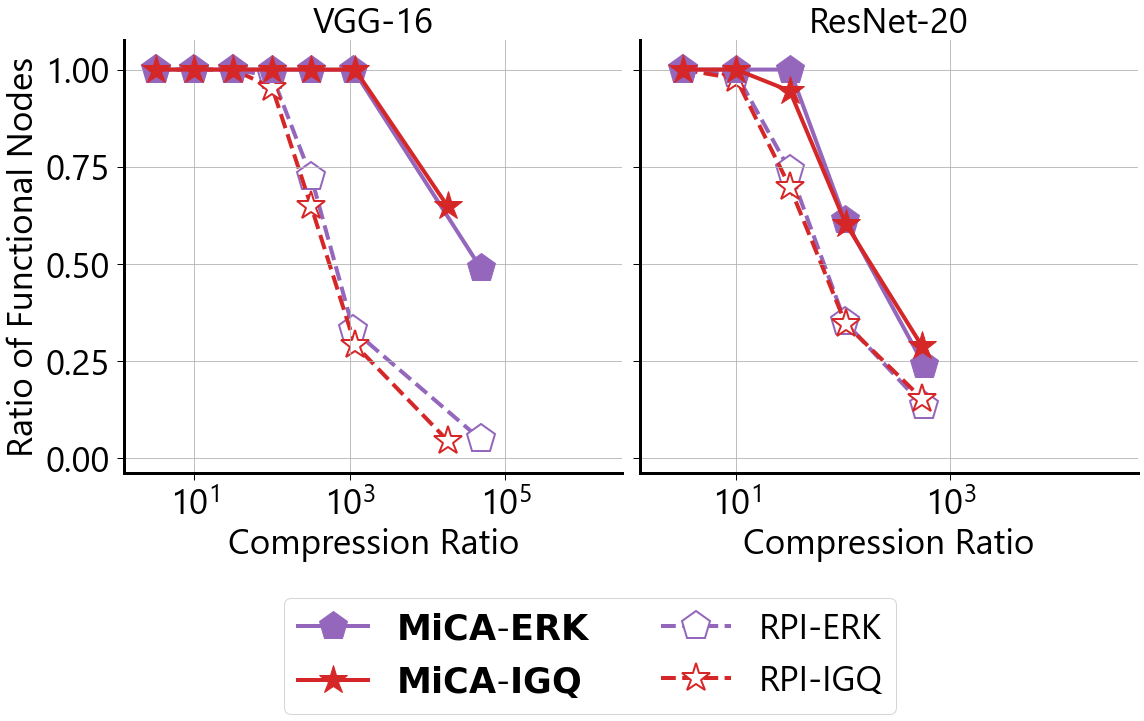

In [13]:
plot_pruners = [
    'mica_erk_rand_effective_comp',
    'mica_erk_shuffle',
    'mica_igq_rand_effective_comp',
    'mica_igq_shuffle',
    ]

lw=4
markersize=30
fontsize=35

plt.rcParams["font.family"] = "Segoe UI"

fig, axes = plt.subplots(1, 2, figsize=(8*2, 8))

for i, arch in enumerate(['vgg', 'resnet']):

    if arch == 'vgg':
        effective_x_ratios = vgg_effective_x_ratios
        pruner_n_mask_V_in = vgg_pruner_n_mask_V_in
        pruner_n_losses    = vgg_pruner_n_losses
        accs               = vgg_accs
        xticks = [10**(2*i - 1) for i in range(1,4)]
    elif arch == 'resnet':
        effective_x_ratios = resnet_effective_x_ratios
        pruner_n_mask_V_in = resnet_pruner_n_mask_V_in
        pruner_n_losses    = resnet_pruner_n_losses
        accs               = resnet_accs
        xticks = [10**(2*i - 1) for i in range(1,6)]
    ax = axes[i]

    zorder = 1
    for l, pruner in enumerate(plot_pruners):
        if '_shuffle' in pruner:
            linestyle = 'dashed'  
            ax.plot(effective_x_ratios[pruner], 
                    1 - np.array(pruner_n_losses[pruner]) / (np.array(pruner_n_mask_V_in[pruner])+np.array(pruner_n_losses[pruner])), 
                    color=colors[pruner], 
                    linestyle=linestyle, lw=lw,
                    marker=markers[pruner], markersize=markersize, markerfacecolor= 'white', markeredgewidth=2,
                    label=pruner_names[pruner],
                    zorder=0)
            zorder += 1
        elif 'mica' in pruner:
            linestyle = 'solid'
            print(pruner)
            print(effective_x_ratios[pruner])
            print(accs[pruner])
            ax.plot(effective_x_ratios[pruner], 
                    1 - np.array(pruner_n_losses[pruner]) / (np.array(pruner_n_mask_V_in[pruner])+np.array(pruner_n_losses[pruner])), 
                    color=colors[pruner], 
                    linestyle=linestyle, lw=lw,
                    marker=markers[pruner], markersize=markersize,  
                    label=pruner_names[pruner],
                    zorder=10)
            zorder += 1

    ax.set_xscale('log')
    ax.set_xticks(xticks)
    ax.set_ylim(-0.0375, 1.075)
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
    ax.minorticks_off()

    ax.tick_params(
        which       = "both", bottom    = True,  top   = False,
        labelbottom = True,   left      = True,  right = False,
        labelleft   = True if arch == 'vgg' else False,   
        direction   = 'out',  length    = 7,     width = 1.0,    
        pad         = 8,      labelsize = fontsize
        )

    ax.set_title('VGG-16' if arch == 'vgg' else 'ResNet-20', size=fontsize)
    ax.set_xlabel('Compression Ratio', size=fontsize)
    if i == 0:
        ax.set_ylabel('Ratio of Functional Nodes', size=fontsize)
        ax.set_xlim(10**0.1, 10**6.5)
    else:
        ax.set_xlim(10**0.1, 10**4.75)
    ax.grid(True)
    ax.set_axisbelow(True)
    

    # boundary and zoom box
    for dir in ["top", "bottom", "right", "left"]:
        ax.spines[dir].set_linewidth(3)
    ax.spines["right"].set_linestyle((0,(3,3)))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

fig.subplots_adjust(hspace=0.2)
fig.tight_layout()

handles, labels = ax.get_legend_handles_labels()
# for nl, label in enumerate(labels):
#     print(f'{nl}, {label}')
order = [0, 2, 1, 3]
ordered_handles = get_ordered_list(handles, order)
ordered_labels = get_ordered_list(labels, order)
plt.legend(
    handles=ordered_handles,labels=ordered_labels, 
    fontsize=fontsize, loc='upper center', 
    bbox_to_anchor=(-.1, -.25), ncol=2)
os.makedirs('Plots', exist_ok=True)
plt.savefig('./Plots/cifar10_mica_rand_functional_nodes.eps', bbox_inches="tight")
plt.savefig('./Plots/cifar10_mica_rand_functional_nodes.svg', bbox_inches="tight")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


mica_cs_rand_effective_comp
[3.1700386515201, 10.095267108879666, 32.87195132279081, 115.54719817470324, 456.6758179628107, 2121.417617907245, nan, nan, nan, nan, nan, nan]
[92.28666667 91.33333333 89.84       87.78       83.94666667 73.29333333
 10.         10.         10.         10.         10.         10.        ]
cs
[3.1700386515201, 10.095267108879666, 32.87195132279081, 115.54719817470324, 456.6758179628107, 2121.417617907245, nan, nan, nan, nan, nan, nan]
[92.26       91.28666667 90.04666667 87.89666667 83.32666667 69.86666667
 10.         10.         10.         10.         10.         10.        ]
mica_grasp_rand_effective_comp
[3.16275951540686, 10.011114824379083, 31.820014839878667, 103.71133290442737, 358.162596148767, nan, nan, nan, nan, nan, nan, nan]
[92.22333333 91.63333333 90.50333333 88.90666667 85.91666667 10.
 10.         10.         10.         10.         10.         10.        ]
grasp
[3.16275951540686, 10.011114824379083, 31.820014839878667, 103.71133290442737

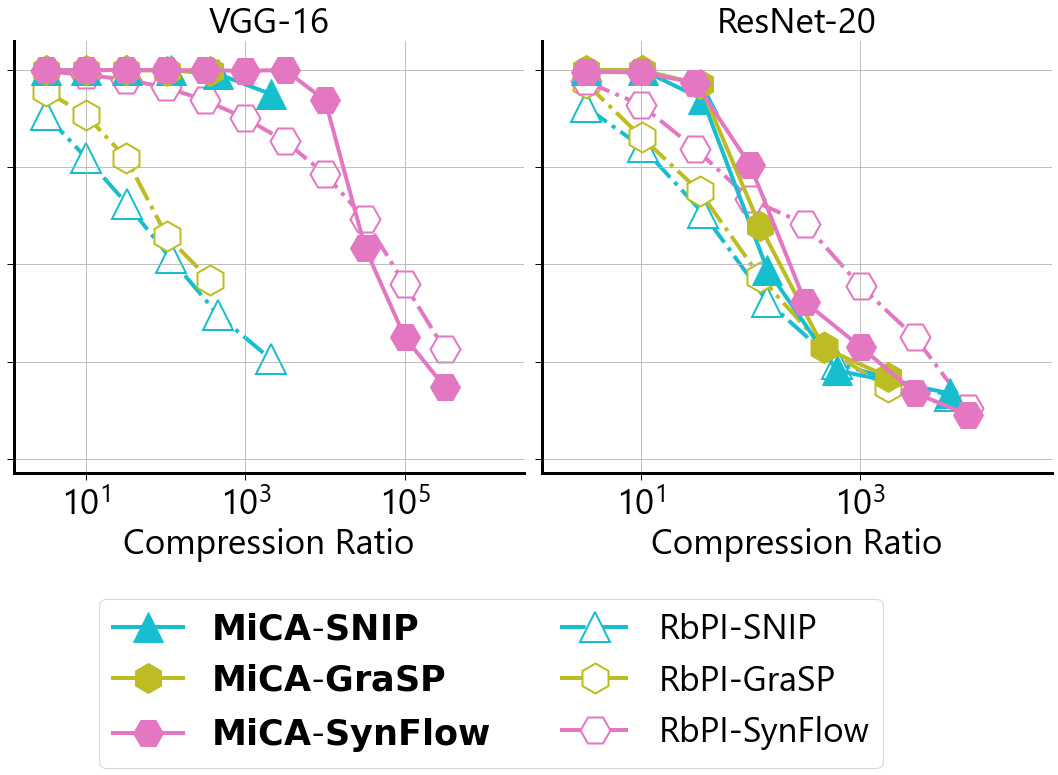

In [14]:
plot_pruners = [
    'mica_cs_rand_effective_comp',
    'cs',
    'mica_grasp_rand_effective_comp',
    'grasp',
    'mica_sf_rand_effective_comp',
    'sf'
    ]

lw=4
markersize=30
fontsize=35

plt.rcParams["font.family"] = "Segoe UI"

fig, axes = plt.subplots(1, 2, figsize=(8*1.851, 8))

for i, arch in enumerate(['vgg', 'resnet']):

    if arch == 'vgg':
        effective_x_ratios = vgg_effective_x_ratios
        pruner_n_mask_V_in = vgg_pruner_n_mask_V_in
        pruner_n_losses    = vgg_pruner_n_losses
        accs               = vgg_accs
        xticks = [10**(2*i - 1) for i in range(1,4)]
    elif arch == 'resnet':
        effective_x_ratios = resnet_effective_x_ratios
        pruner_n_mask_V_in = resnet_pruner_n_mask_V_in
        pruner_n_losses    = resnet_pruner_n_losses
        accs               = resnet_accs
        xticks = [10**(2*i - 1) for i in range(1,4)]
    ax = axes[i]

    zorder = 1
    for l, pruner in enumerate(plot_pruners):
        if 'mica' in pruner:
            linestyle = 'solid'
            print(pruner)
            print(effective_x_ratios[pruner])
            print(accs[pruner])
            ax.plot(effective_x_ratios[pruner], 
                    1 - np.array(pruner_n_losses[pruner]) / (np.array(pruner_n_mask_V_in[pruner])+np.array(pruner_n_losses[pruner])), 
                    color=colors[pruner], 
                    linestyle=linestyle, lw=lw,
                    marker=markers[pruner], markersize=markersize,  
                    label=pruner_names[pruner],
                    zorder=10)
            zorder += 1
        else:
            linestyle = 'dashdot'
            print(pruner)
            print(effective_x_ratios[pruner])
            print(accs[pruner])
            ax.plot(effective_x_ratios[pruner], 
                    1 - np.array(pruner_n_losses[pruner]) / (np.array(pruner_n_mask_V_in[pruner])+np.array(pruner_n_losses[pruner])), 
                    color=colors[pruner], 
                    linestyle=linestyle, lw=lw,
                    marker=markers[pruner], markersize=markersize,  
                    markerfacecolor= 'white', markeredgewidth=2,
                    label=pruner_names[pruner],
                    zorder=-10)
            zorder += 1

    ax.set_xscale('log')
    ax.set_xticks(xticks)
    ax.set_ylim(-0.0375, 1.075)
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
    ax.minorticks_off()

    ax.tick_params(
        which       = "both", bottom    = True,  top   = False,
        labelbottom = True,   left      = True,  right = False,
        labelleft   =  False,   
        direction   = 'out',  length    = 7,     width = 1.0,    
        pad         = 8,      labelsize = fontsize
        )

    ax.set_title('VGG-16' if arch == 'vgg' else 'ResNet-20', size=fontsize)
    ax.set_xlabel('Compression Ratio', size=fontsize)
    if i == 0:
        ax.set_xlim(10**0.1, 10**6.5)
    else:
        ax.set_xlim(10**0.1, 10**4.75)
    ax.grid(True)
    ax.set_axisbelow(True)
    

    # boundary and zoom box
    for dir in ["top", "bottom", "right", "left"]:
        ax.spines[dir].set_linewidth(3)
    ax.spines["right"].set_linestyle((0,(3,3)))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

fig.subplots_adjust(hspace=0.2)
fig.tight_layout()

handles, labels = ax.get_legend_handles_labels()
# for nl, label in enumerate(labels):
#     print(f'{nl}, {label}')
order = [0, 2, 4, 1, 3, 5]
ordered_handles = get_ordered_list(handles, order)
ordered_labels = get_ordered_list(labels, order)
plt.legend(
    handles=ordered_handles,labels=ordered_labels, 
    fontsize=fontsize, loc='upper center', 
    bbox_to_anchor=(-.1, -.25), ncol=2)
os.makedirs('Plots', exist_ok=True)
plt.savefig('./Plots/cifar10_mica_rank_functional_nodes.eps', bbox_inches="tight")
plt.savefig('./Plots/cifar10_mica_rank_functional_nodes.svg', bbox_inches="tight")